word2vec + textrank
POS dengan fiture phrase detection berbasis pola POS

In [1]:
#1. rutin1 import module
import pandas as pd
import os
import sys
import warnings
import matplotlib.pyplot as plt
#from sklearn.metrics.pairwise import cosine_similarity

warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
#2. rutin2 membuat syspath ke root utk aktifkan __init__.py
repo_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(repo_root)

In [3]:
#3. rutin3 Load the dataset
#dataset_path = os.path.join(repo_root, "notebooks/postager_nlp-id/dataset_ekstraksi_r29_pos_sm.xlsx")
dataset_path = os.path.join(repo_root, "data/dataset_ekstraksi_r30_lg.xlsx")
df = pd.read_excel(dataset_path)
df["text"] = df["judul"] +". "+ df["isi"]
#df_pos = df['pos_sentence_list']

In [4]:
# Preprocess
import re
'''
stopwords tidak masuk dalam preprocessing
'''
def preprocess(text):
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    text = text.replace('.', '. ')
    text = re.sub('[^a-zA-Z.]', ' ', text)
    text = text.lower()
    text = re.sub("(\\d|\\W)+"," ",text)
    text = text.strip()

    return text

df["text"] = df['text'].apply(preprocess)
df["judul"] = df["judul"].apply(preprocess)

Process

In [5]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

from nltk.util import ngrams

def generate_ngrams(words, n=2):
    """Generate ngrams from a list of words."""
    return [" ".join(gram) for gram in ngrams(words, n)]

def get_phrase_embedding(phrase, w2v_model):
    """Get the averaged word embedding for a phrase."""
    words = phrase.split()
    embeddings = [w2v_model.wv[word] for word in words if word in w2v_model.wv.key_to_index]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return None

from collections import Counter
from nlp_id_local.tokenizer import PhraseTokenizer 
from nlp_id_local.postag import PosTag


model_path = os.path.join(repo_root, "notebooks/nlp-id_retraining/train_tuned.pkl") #add_8
#model_path = os.path.join(repo_root, "src/adj_textrank/nlp_id_local/data/postagger_v9.pkl") #add_8

def detect_bigram(text, available_tokens,):
    
    tokenizer = PhraseTokenizer()
    phrases = tokenizer.tokenize(text)
    # Include only bigrams whose individual words are in available_tokens
    bigrams_only = [phrase for phrase in phrases if phrase.count(" ") == 1 and all(word in available_tokens for word in phrase.split())]

    return bigrams_only

def detect_trigram(text, available_tokens):

    tokenizer = PhraseTokenizer()
    phrases = tokenizer.tokenize(text)
    # Include only trigrams whose individual words are in available_tokens
    trigrams_only = [phrase for phrase in phrases if phrase.count(" ") == 2 and all(word in available_tokens for word in phrase.split())]

    return trigrams_only

def get_unique_tokens_pos(all_tokens, model_path):
    """
    Get unique POS tags for tokens.
    """
    postagger = PosTag(model_path)
    pos_tokens = []
    seen_tokens = set()
    
    for token in all_tokens:
        if token not in seen_tokens:
            seen_tokens.add(token)
            tokens_pos = postagger.get_phrase_tag(token)
            pos_tokens.append(tokens_pos)
    return pos_tokens


def flatten_list_of_lists(list_of_lists):
    """
    Flatten a list of lists into a single list.
    """
    return [item for sublist in list_of_lists for item in sublist]


def filter_tokens_by_pos(flat_tokens, pos_filters):
    """
    Filter tokens based on their POS tags and ensure they're unique.
    """
    seen_tokens = set()
    return [token[0] for token in flat_tokens if token[1] in pos_filters and not (token[0] in seen_tokens or seen_tokens.add(token[0]))]

def extract_keyphrases_with_ngrams_graph(text, w2v_model, judul, available_tokens, n=10):
    # Read stopwords from the file
    stopwords_path = os.path.join(repo_root, "notebooks/stopwords_tuning/all_stop_words.txt")
    with open(stopwords_path, 'r') as file:
        stopwords = set(file.read().strip().splitlines())

    # Tokenize the text into unigrams that are in available_tokens
    unigrams = [word for word in text.split() if word not in stopwords and word in available_tokens]

    # Generate bigrams and trigrams using nlp-id
    bigrams = detect_bigram(text, available_tokens)
    trigrams = detect_trigram(text, available_tokens)
    
    # Combine unigrams, filtered bigrams, and filtered trigrams
    all_tokens = unigrams + bigrams + trigrams

    # Filter tokens only for selected POS
#    pos_tokens = get_unique_tokens_pos(all_tokens, model_path)
#    flat_pos_tokens = flatten_list_of_lists(pos_tokens)
#    selected_pos = {'NN', 'NNP', 'VB', 'NP', 'VP'} # FW di exclude
#    filtered_tokens = filter_tokens_by_pos(flat_pos_tokens, selected_pos)

    # Get embeddings for each token (averaging word embeddings for bigrams/trigrams)
    token_embeddings = [get_phrase_embedding(token, w2v_model) for token in all_tokens]
    
    # Filter out tokens that don't have embeddings
    tokens, embeddings = zip(*[(token, emb) for token, emb in zip(all_tokens, token_embeddings) if emb is not None])

    # Compute the cosine similarity between token embeddings
    cosine_matrix = cosine_similarity(embeddings)
    
    # Create a graph and connect tokens with high similarity
    G = nx.Graph()
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            if cosine_matrix[i][j] > 0.5:  # This threshold can be adjusted
                G.add_edge(tokens[i], tokens[j], weight=cosine_matrix[i][j])
    
    # Create labels dictionary using the tokens
    labels = {token: token for token in tokens}

    # Compute the PageRank scores to rank the tokens
    scores = nx.pagerank(G)

    # Modify scores if token is in title letter
#    for token in scores:
#        if any(token in title for title in judul):
#            scores[token] *= 2

    # Extract top N keyphrases along with their scores
    ranked_tokens = sorted(((scores[token], token) for token in tokens if token in scores), reverse=True)
    
    keyphrases_with_scores = []
    seen_tokens = set()  # Set to keep track of tokens that have already been added

    for score, token in ranked_tokens:
        if token not in seen_tokens:
            keyphrases_with_scores.append((token, score))
            seen_tokens.add(token)  # Mark the token as seen
            if len(keyphrases_with_scores) >= n:
                break  # Stop when the desired number of keyphrases is reached

    return keyphrases_with_scores, G, labels


def visualize_graph(G, labels):

    # Remove self-loops (edges that connect a node to itself)
    G.remove_edges_from(nx.selfloop_edges(G))

    fig = plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=False, font_weight="bold")
    nx.draw_networkx_labels(G, pos, labels)
    plt.show()

In [6]:
w2v_path = os.path.join(repo_root, "models/own_dataset/word2vec_model_surat_lg.model")
w2v_model = Word2Vec.load(w2v_path)

# Get available tokens from the Word2Vec model
available_tokens = set(w2v_model.wv.key_to_index)

In [19]:
text = df["text"][1]
print(text)

'template document jtb gpf project mengacu kepada dokumen jtb cp ctr exhibit coordination procedure kami sampaikan template document yang akan dipergunakan pada proyek jambaran tiung biru jtb gas processing facilities gpf demikian disampaikan sebagai acuan pengelolaan dokumen atas perhatiannya kami ucapkan terima kasih'

In [20]:
available_tokens = set(w2v_model.wv.key_to_index)
print(available_tokens)

{'kedua', 'petugas', 'instrumen', 'pekerjaanproyek', 'djp', 'pemeriksaaan', 'melampirkanz', 'lighting', 'membayar', 'mengkomunikasikan', 'psl', 'damage', 'skkmigooo', 'muabdulrodi', 'pemberlakuan', 'tindakan', 'tf', 'apu', 'dari', 'tokoh', 'products', 'nllai', 'membatalkan', 'activity', 'vaporizer', 'sebeium', 'terbaru', 'hengyang', 'rigging', 'mengimplementasikannya', 'electrical', 'pandemic', 'pejabat', 'agru', 'hitoshi', 'sasaranl', 'berlaku', 'drivers', 'sekurang', 'ijinimpor', 'erkait', 'developed', 'percepatan', 'acceptable', 'teliti', 'merekomendasikan', 'miscellaneous', 'vii', 'candle', 'melanjutkan', 'ga', 'berkendaran', 'jam', 'mill', 'mengembangkan', 'priyanto', 'juga', 'bt', 'menggaransi', 'kelanjutan', 'jseaiess', 'antrean', 'sesegera', 'kok', 'pemaparan', 'waiting', 'reset', 'quali', 'penyewaan', 'merencakan', 'nol', 'yyf', 'unyuk', 'wardhana', 'menoatat', 'selektif', 'tinggal', 'mengubah', 'pembuatan', 'pembentukan', 'minim', 'masuknya', 'vesel', 'dikomentari', 'digunaka

In [25]:
stopwords_path = os.path.join(repo_root, "notebooks/stopwords_tuning/all_stop_words.txt")
with open(stopwords_path, 'r') as file:
    stopwords = set(file.read().strip().splitlines())

# Tokenize the text into unigrams that are in available_tokens
unigrams = [word for word in text.split() if word not in stopwords and word in available_tokens]
bigrams = detect_bigram(text, available_tokens)
trigrams = detect_trigram(text, available_tokens)
all_tokens = unigrams + bigrams + trigrams
print(all_tokens)

['template', 'document', 'project', 'mengacu', 'ctr', 'exhibit', 'coordination', 'procedure', 'template', 'document', 'jambaran', 'tiung', 'biru', 'processing', 'facilities', 'acuan', 'pengelolaan', 'perhatiannya', 'template document', 'template document']


In [42]:
token_embeddings = [get_phrase_embedding(token, w2v_model) for token in all_tokens]
print(token_embeddings)

[array([ 0.05001955,  0.0221506 , -0.00153262,  0.01135013,  0.11258701,
       -0.07912592,  0.01815206,  0.20223385, -0.08514582, -0.00135354,
       -0.12750185, -0.14805798,  0.01003275,  0.07419394, -0.03169027,
       -0.03345745, -0.01401462, -0.05269181, -0.01668345, -0.13713996,
       -0.00255622, -0.04510522,  0.05837847,  0.0114586 , -0.02359542,
       -0.11845393, -0.05163258, -0.04663118, -0.02070628,  0.01705443,
        0.05954687,  0.13043886,  0.01542062, -0.08611028,  0.05586781,
        0.11194495,  0.08525772, -0.00997564, -0.03709879, -0.12306785,
       -0.02608321, -0.00446764, -0.08278894,  0.00721507,  0.05331475,
       -0.05356549, -0.00100807,  0.01709415,  0.04642154,  0.02516942,
       -0.00384825,  0.01113134,  0.01275506, -0.07376181, -0.03872823,
       -0.05344334,  0.00848936, -0.10232605, -0.062053  ,  0.00912554,
        0.01773996, -0.03720296, -0.03953846, -0.02245064, -0.10187591,
        0.09320424,  0.05149451,  0.16249782, -0.10082521,  0.1

In [41]:
tokens, embeddings = zip(*[(token, emb) for token, emb in zip(all_tokens, token_embeddings) if emb is not None])
print(tokens)
print(embeddings)

('template', 'document', 'project', 'mengacu', 'ctr', 'exhibit', 'coordination', 'procedure', 'template', 'document', 'jambaran', 'tiung', 'biru', 'processing', 'facilities', 'acuan', 'pengelolaan', 'perhatiannya', 'template document', 'template document')
(array([ 0.05001955,  0.0221506 , -0.00153262,  0.01135013,  0.11258701,
       -0.07912592,  0.01815206,  0.20223385, -0.08514582, -0.00135354,
       -0.12750185, -0.14805798,  0.01003275,  0.07419394, -0.03169027,
       -0.03345745, -0.01401462, -0.05269181, -0.01668345, -0.13713996,
       -0.00255622, -0.04510522,  0.05837847,  0.0114586 , -0.02359542,
       -0.11845393, -0.05163258, -0.04663118, -0.02070628,  0.01705443,
        0.05954687,  0.13043886,  0.01542062, -0.08611028,  0.05586781,
        0.11194495,  0.08525772, -0.00997564, -0.03709879, -0.12306785,
       -0.02608321, -0.00446764, -0.08278894,  0.00721507,  0.05331475,
       -0.05356549, -0.00100807,  0.01709415,  0.04642154,  0.02516942,
       -0.00384825,  0

In [ ]:
cosine_sim = cosine_similarity('template', 'document')
cosine_sim


In [55]:
print(cosine_matrix[1][2])

0.75170267


In [48]:
cosine_matrix = cosine_similarity(embeddings)
print(cosine_matrix)
print(cosine_matrix.shape)

[[ 1.0000002   0.94164896  0.6724556   0.6335748   0.28297332  0.7268255
   0.9256347   0.9474575   1.0000002   0.94164896  0.6741752   0.6617998
   0.63084555  0.8192112   0.6796033   0.949383    0.9273763   0.58163
   0.9656      0.9656    ]
 [ 0.94164896  0.9999999   0.75170267  0.76289785  0.4719752   0.9096529
   0.9490128   0.93377364  0.94164896  0.9999999   0.6397878   0.68632
   0.67475235  0.75757843  0.73307973  0.8938883   0.796473    0.3506549
   0.9967821   0.9967821 ]
 [ 0.6724556   0.75170267  1.0000001   0.89794195  0.7066416   0.7321371
   0.86753714  0.78672814  0.6724556   0.75170267  0.77867407  0.8381097
   0.86185455  0.8527357   0.89606696  0.57339215  0.4555193   0.10789704
   0.7408576   0.7408576 ]
 [ 0.6335748   0.76289785  0.89794195  0.9999999   0.7525819   0.7867362
   0.8311284   0.70839864  0.6335748   0.76289785  0.5899999   0.69647676
   0.7451641   0.67351854  0.7482255   0.52524287  0.42001224  0.07296181
   0.7402469   0.7402469 ]
 [ 0.28297332  0.

In [53]:
G = nx.Graph()
for i in range(len(tokens)):
    for j in range(len(tokens)):
        if cosine_matrix[i][j] > 0.9:  # This threshold can be adjusted
            G.add_edge(tokens[i], tokens[j], weight=cosine_matrix[i][j])
    
# Create labels dictionary using the tokens
labels = {token: token for token in tokens}

# Compute the PageRank scores to rank the tokens
scores = nx.pagerank(G)

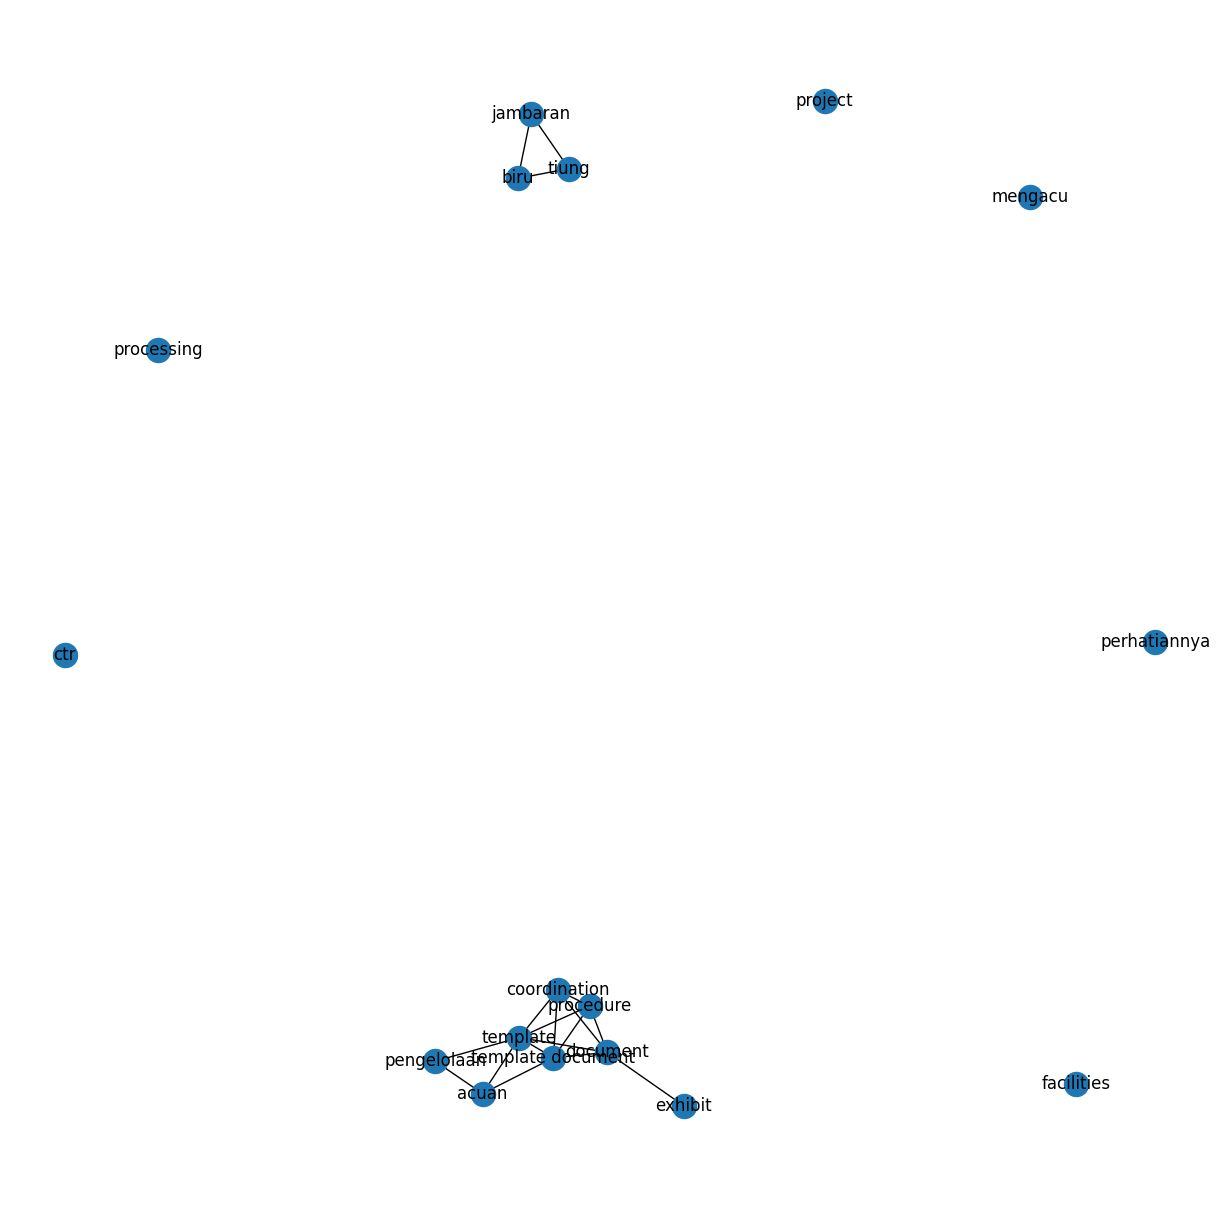

In [54]:
visualize_graph(G, labels)

In [34]:
scores

{'template': 0.0689066185982226,
 'document': 0.06628836691010184,
 'project': 0.06459569384451977,
 'mengacu': 0.06065859082833288,
 'exhibit': 0.05973120080157158,
 'coordination': 0.0715754577356441,
 'procedure': 0.07302039680676571,
 'jambaran': 0.053910169750068834,
 'tiung': 0.057902940529103226,
 'biru': 0.05525621674279955,
 'processing': 0.06436552111102914,
 'facilities': 0.0650544410230752,
 'acuan': 0.0619497300601477,
 'pengelolaan': 0.05049439469700755,
 'perhatiannya': 0.027485434568294373,
 'template document': 0.06661398078161515,
 'ctr': 0.0321908452117008}

In [35]:
ranked_tokens = sorted(((scores[token], token) for token in tokens if token in scores), reverse=True)
ranked_tokens

[(0.07302039680676571, 'procedure'),
 (0.0715754577356441, 'coordination'),
 (0.0689066185982226, 'template'),
 (0.0689066185982226, 'template'),
 (0.06661398078161515, 'template document'),
 (0.06661398078161515, 'template document'),
 (0.06628836691010184, 'document'),
 (0.06628836691010184, 'document'),
 (0.0650544410230752, 'facilities'),
 (0.06459569384451977, 'project'),
 (0.06436552111102914, 'processing'),
 (0.0619497300601477, 'acuan'),
 (0.06065859082833288, 'mengacu'),
 (0.05973120080157158, 'exhibit'),
 (0.057902940529103226, 'tiung'),
 (0.05525621674279955, 'biru'),
 (0.053910169750068834, 'jambaran'),
 (0.05049439469700755, 'pengelolaan'),
 (0.0321908452117008, 'ctr'),
 (0.027485434568294373, 'perhatiannya')]

In [ ]:
def extract_keyphrases_with_ngrams_graph(text, w2v_model, judul, available_tokens, n=10):
        # Create a graph and connect tokens with high similarity
    
    keyphrases_with_scores = []
    seen_tokens = set()  # Set to keep track of tokens that have already been added

    for score, token in ranked_tokens:
        if token not in seen_tokens:
            keyphrases_with_scores.append((token, score))
            seen_tokens.add(token)  # Mark the token as seen
            if len(keyphrases_with_scores) >= n:
                break  # Stop when the desired number of keyphrases is reached

    return keyphrases_with_scores, G, labels

In [7]:
predict_textrank = pd.DataFrame()
#for i in df.index:
for i in df.loc[:2].index:
    print('Processing index', i, end='...! ')
    text = df["text"][i] # sblm di preprocess
    #text = df_tr[i] # setelah di preprocess
    ls_judul = preprocess(df["judul"][i]).split()
    keyphrases,_,_ = extract_keyphrases_with_ngrams_graph(text, w2v_model, ls_judul, available_tokens, 10)
    df_keyphrases = pd.DataFrame(keyphrases, columns=['Keyword', 'Score'])
    a = pd.DataFrame(df_keyphrases.Keyword).T.reset_index(drop=True)
    b = pd.DataFrame(df_keyphrases.Score).round(3).T.reset_index(drop=True)
    df_keyphrases = pd.concat([a, b], axis=1)

    # Check if there are missing columns and add them with zero values
    missing_columns = 20 - df_keyphrases.shape[1]
    for _ in range(missing_columns):
        df_keyphrases[df_keyphrases.shape[1]] = 0

    #df_keyphrases.columns = ['key_1', 'key_2','key_3','score_1', 'score_2','score_3']
    df_keyphrases.columns = ['key_1', 'key_2','key_3', 'key_4', 'key_5','key_6', 'key_7', 'key_8','key_9','key_10','score_1', 'score_2','score_3','score_4', 'score_5','score_6','score_7', 'score_8','score_9','score_10'] 
    predict_textrank = pd.concat([predict_textrank, df_keyphrases], ignore_index=True)
    print('Done')
predict_textrank.head(3)

Processing index 0...! Done
Processing index 1...! Done
Processing index 2...! Done


,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10
0,mengharapkan,informasi,prosedur,perbedaan,penjelasan,usulan personil penting,memiliki,usulan baru,kandidat,organisasi,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015
1,procedure,coordination,template,template document,document,facilities,project,processing,acuan,mengacu,0.073,0.072,0.069,0.067,0.066,0.065,0.065,0.064,0.062,0.061
2,artikel,mengubah,tabel,akomodasi,persyaratan,ruang,klarifikasi,mingguan,tabel lain,table,0.020,0.020,0.020,0.020,0.019,0.019,0.019,0.019,0.019,0.019


EVALUATION

In [8]:
from utils import eval

targets = df[["k1", "k2", "k3","k4", "k5", "k6","k7"]].values.tolist()
df_targets = pd.DataFrame(targets)

In [9]:
# Evaluation TextRank top 10
predict_textrank_list_10 = predict_textrank[['key_1','key_2','key_3', 'key_4','key_5','key_6', 'key_7','key_8','key_9', 'key_10']].values.tolist()
eval_textrank_10 = eval(predict_textrank_list_10, targets, True).round(3)
eval_textrank_10.columns = ['key_1','key_2','key_3', 'key_4','key_5','key_6', 'key_7','key_8','key_9', 'key_10','strict_recall', 'strict_prec', 'flex_recall','flex_prec']
eval_textrank_10 = eval_textrank_10[['key_1','key_2','key_3', 'key_4','key_5','key_6', 'key_7','key_8','key_9', 'key_10', 'flex_recall','flex_prec']] # untuk menyederhanakan hasil evaluasi
eval_textrank_10.head(3)

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,flex_recall,flex_prec
0,no_match,no_match,full_match,no_match,no_match,no_match,no_match,no_match,no_match,no_match,0.143,0.1
1,no_match,no_match,partial_match,full_match,partial_match,no_match,no_match,no_match,full_match,no_match,0.571,0.4
2,no_match,no_match,no_match,full_match,no_match,partial_match,no_match,no_match,no_match,no_match,0.286,0.2


In [10]:
# Calculate TextRank Score, using flexible score : exact maatch =1, partial match = 1, no match = 0
textrank_recall_10 = eval_textrank_10['flex_recall'].mean()
textrank_prec_10 = eval_textrank_10['flex_prec'].mean()
textrank_f1_10 = 2 * (textrank_prec_10 * textrank_recall_10) / (textrank_prec_10 + textrank_recall_10)

# Create a DataFrame with the scores
summary_10 = pd.DataFrame({'textrank': [textrank_recall_10, textrank_prec_10, textrank_f1_10]}, index=['recall', 'precision', 'F1'])
summary_10 = summary_10.round(3)
summary_10

,textrank
recall,0.333
precision,0.233
F1,0.275


In [11]:
# Evaluation TextRank top 5
predict_textrank_list_5 = predict_textrank[['key_1','key_2','key_3', 'key_4','key_5']].values.tolist()
eval_textrank_5 = eval(predict_textrank_list_5, targets, True).round(3)
eval_textrank_5.columns = ['key_1','key_2','key_3', 'key_4','key_5','strict_recall', 'strict_prec', 'flex_recall','flex_prec']
eval_textrank_5 = eval_textrank_5[['key_1','key_2','key_3', 'key_4','key_5', 'flex_recall','flex_prec']] # untuk menyederhanakan hasil evaluasi
eval_textrank_5.head(3)

,key_1,key_2,key_3,key_4,key_5,flex_recall,flex_prec
0,no_match,no_match,full_match,no_match,no_match,0.143,0.2
1,no_match,no_match,partial_match,full_match,partial_match,0.429,0.6
2,no_match,no_match,no_match,full_match,no_match,0.143,0.2


In [12]:
# Calculate TextRank Score, using flexible score : exact maatch =1, partial match = 1, no match = 0
textrank_recall_5 = eval_textrank_5['flex_recall'].mean()
textrank_prec_5 = eval_textrank_5['flex_prec'].mean()
textrank_f1_5 = 2 * (textrank_prec_5 * textrank_recall_5) / (textrank_prec_5 + textrank_recall_5)

# Create a DataFrame with the scores
summary_5 = pd.DataFrame({'textrank': [textrank_recall_5, textrank_prec_5, textrank_f1_5]}, index=['recall', 'precision', 'F1'])
summary_5 = summary_5.round(3)
summary_5

,textrank
recall,0.238
precision,0.333
F1,0.278


In [13]:
# Evaluation TextRank top 3
predict_textrank_list_3 = predict_textrank[['key_1','key_2','key_3']].values.tolist()
eval_textrank_3 = eval(predict_textrank_list_3, targets, True).round(3)
eval_textrank_3.columns = ['key_1', 'key_2','key_3','strict_recall', 'strict_prec', 'flex_recall','flex_prec']
eval_textrank_3 = eval_textrank_3[['key_1', 'key_2','key_3', 'flex_recall','flex_prec']] # untuk menyederhanakan hasil evaluasi
eval_textrank_3.head(3)

,key_1,key_2,key_3,flex_recall,flex_prec
0,no_match,no_match,full_match,0.143,0.333
1,no_match,no_match,partial_match,0.143,0.333
2,no_match,no_match,no_match,0.000,0.000


In [14]:
# Calculate TextRank Score, using flexible score : exact maatch =1, partial match = 1, no match = 0
textrank_recall_3 = eval_textrank_3['flex_recall'].mean()
textrank_prec_3 = eval_textrank_3['flex_prec'].mean()
textrank_f1_3 = 2 * (textrank_prec_3 * textrank_recall_3) / (textrank_prec_3 + textrank_recall_3)

# Create a DataFrame with the scores
summary_3 = pd.DataFrame({'textrank': [textrank_recall_3, textrank_prec_3, textrank_f1_3]}, index=['recall', 'precision', 'F1'])
summary_3 = summary_3.round(3)
summary_3

,textrank
recall,0.095
precision,0.222
F1,0.133


In [15]:
# Combine dataframe predict_textrank, df_targets and eval_textrank
predict_textrank_10 = pd.concat([predict_textrank, df_targets, eval_textrank_10], axis=1)
predict_textrank_10.head(3)

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,...,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,flex_recall,flex_prec
0,mengharapkan,informasi,prosedur,perbedaan,penjelasan,usulan personil penting,memiliki,usulan baru,kandidat,organisasi,...,full_match,no_match,no_match,no_match,no_match,no_match,no_match,no_match,0.143,0.1
1,procedure,coordination,template,template document,document,facilities,project,processing,acuan,mengacu,...,partial_match,full_match,partial_match,no_match,no_match,no_match,full_match,no_match,0.571,0.4
2,artikel,mengubah,tabel,akomodasi,persyaratan,ruang,klarifikasi,mingguan,tabel lain,table,...,no_match,full_match,no_match,partial_match,no_match,no_match,no_match,no_match,0.286,0.2


In [16]:
# Combine dataframe predict_textrank, df_targets and eval_textrank
predict_textrank_5 = pd.concat([predict_textrank, df_targets, eval_textrank_5], axis=1)
predict_textrank_5.head(3)

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,...,4,5,6,key_1,key_2,key_3,key_4,key_5,flex_recall,flex_prec
0,mengharapkan,informasi,prosedur,perbedaan,penjelasan,usulan personil penting,memiliki,usulan baru,kandidat,organisasi,...,NaN,NaN,NaN,no_match,no_match,full_match,no_match,no_match,0.143,0.2
1,procedure,coordination,template,template document,document,facilities,project,processing,acuan,mengacu,...,dokumen,NaN,NaN,no_match,no_match,partial_match,full_match,partial_match,0.429,0.6
2,artikel,mengubah,tabel,akomodasi,persyaratan,ruang,klarifikasi,mingguan,tabel lain,table,...,services for company,exhibit a,NaN,no_match,no_match,no_match,full_match,no_match,0.143,0.2


In [17]:
# Combine dataframe predict_textrank, df_targets and eval_textrank
predict_textrank_3 = pd.concat([predict_textrank, df_targets, eval_textrank_3], axis=1)
predict_textrank_3.head(3)

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,...,2,3,4,5,6,key_1,key_2,key_3,flex_recall,flex_prec
0,mengharapkan,informasi,prosedur,perbedaan,penjelasan,usulan personil penting,memiliki,usulan baru,kandidat,organisasi,...,usulan,pengganti,NaN,NaN,NaN,no_match,no_match,full_match,0.143,0.333
1,procedure,coordination,template,template document,document,facilities,project,processing,acuan,mengacu,...,acuan,pengelolaan,dokumen,NaN,NaN,no_match,no_match,partial_match,0.143,0.333
2,artikel,mengubah,tabel,akomodasi,persyaratan,ruang,klarifikasi,mingguan,tabel lain,table,...,lingkup kerja,akomodasi,services for company,exhibit a,NaN,no_match,no_match,no_match,0.000,0.000
